In [32]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201  # Use DenseNet201 instead of DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [33]:
# Paths to your local dataset
base_dir = '/kaggle/input/rp-rice-leaf-dataset/Rice Leaf Diseases Dataset'

In [34]:
# Image dimensions and batch size
img_height, img_width = 320, 320
batch_size = 32

In [35]:
# Data augmentation with additional techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [36]:
# Load the DenseNet201 model with pre-trained weights, excluding the top layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [37]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(4, activation='softmax')(x)  # 4 classes

In [38]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [39]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weights_dict
)

Epoch 1/20


2024-10-08 10:53:20.129350: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_394394__.89640] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
I0000 00:00:1728384816.885497     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_79', 24 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_14', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_15', 60 bytes spill stores, 60 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_16', 24 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to

400/400 ━━━━━━━━━━━━━━━━━━━━ 854s 1s/step - accuracy: 0.8694 - loss: 0.3338 - val_accuracy: 0.7619 - val_loss: 1.5479 - learning_rate: 1.0000e-04
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.9834 - loss: 0.0522 - val_accuracy: 0.7638 - val_loss: 1.8176 - learning_rate: 1.0000e-04
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.9885 - loss: 0.0370 - val_accuracy: 0.7506 - val_loss: 1.7457 - learning_rate: 1.0000e-04
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.9890 - loss: 0.0385 - val_accuracy: 0.7531 - val_loss: 2.0550 - learning_rate: 1.0000e-04
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.9931 - loss: 0.0202 - val_accuracy: 0.7100 - val_loss: 2.6416 - learning_rate: 1.0000e-04
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.9940 - loss: 0.0191 - val_accuracy: 0.7594 - val_loss: 1.7864 - learning_rate: 1.0000e-04
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.99

In [42]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7792 - loss: 1.4475
Validation accuracy: 0.76


In [43]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

100/100 ━━━━━━━━━━━━━━━━━━━━ 111s 966ms/step


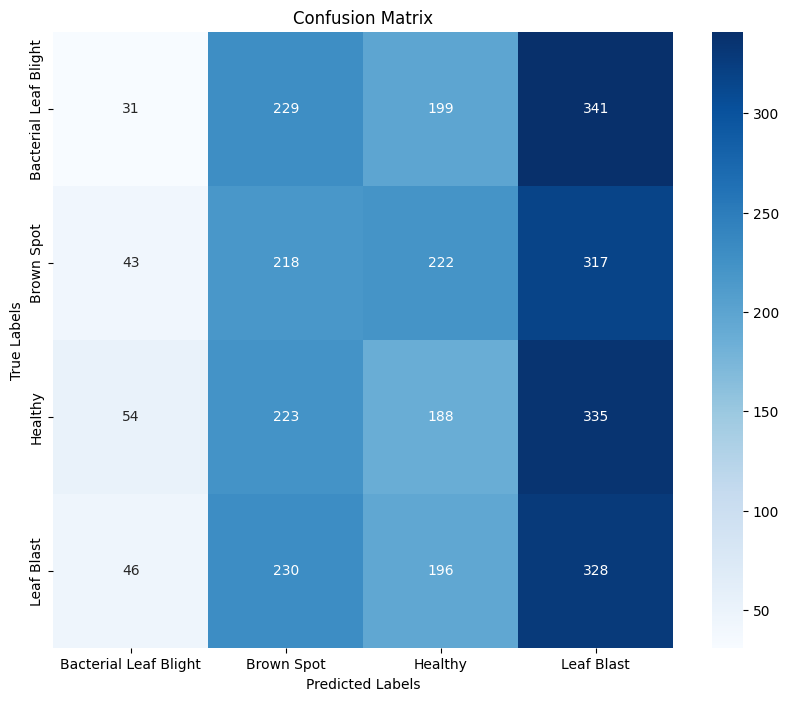

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.18      0.04      0.06       800
           Brown Spot       0.24      0.27      0.26       800
              Healthy       0.23      0.23      0.23       800
           Leaf Blast       0.25      0.41      0.31       800

             accuracy                           0.24      3200
            macro avg       0.23      0.24      0.22      3200
         weighted avg       0.23      0.24      0.22      3200



In [44]:
# Predict the validation data
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))